# Convolution Neural Networks

In [1]:
import torch
import numpy as np

## Loading the DATA

In [2]:
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

num_workers = 0
batch_size = 20
valid_size = 0.2

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          num_workers=num_workers)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


## Visualizing the data

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = img/2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))

<ipython-input-4-ab31463b682e>:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


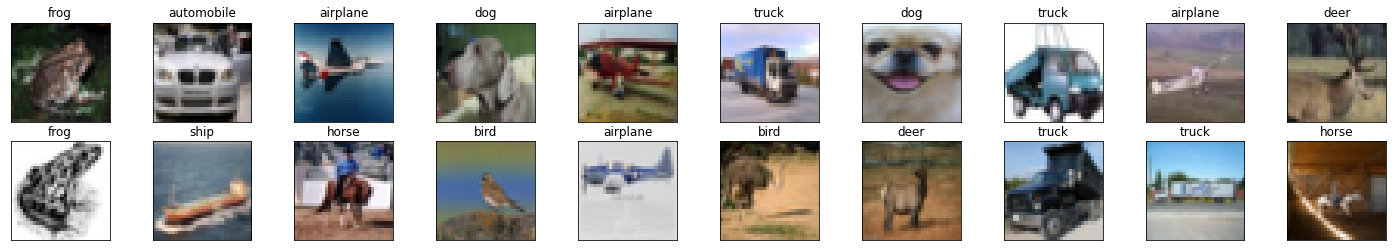

In [4]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

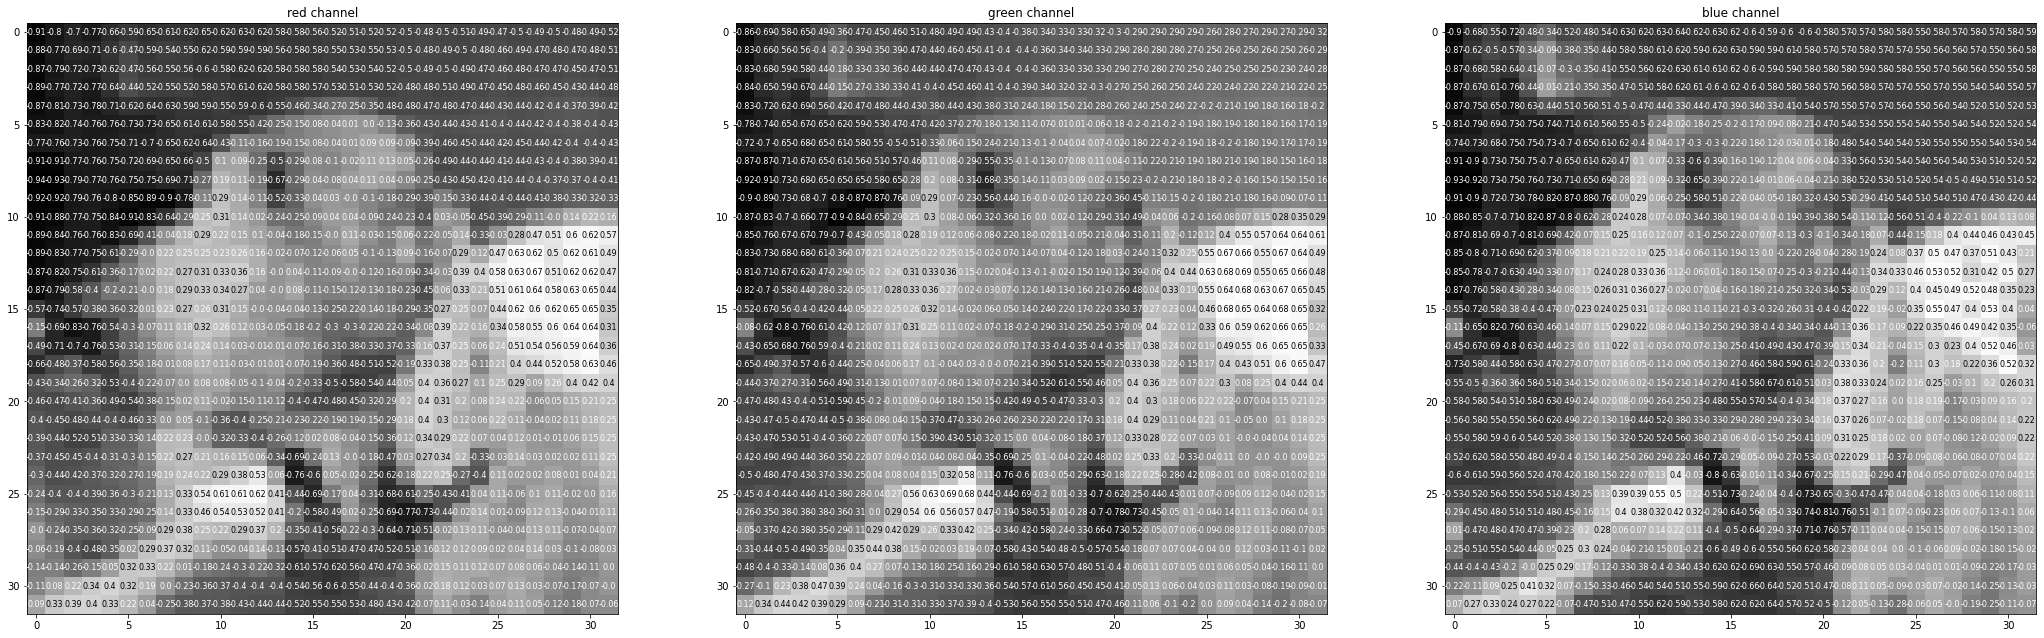

In [5]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

## Defining the Network Architecture

In [6]:
from torch import nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(4 * 4 * 128, 512)
        self.fc2 = nn.Linear(512, 128)
        self.output = nn.Linear(128, 10)
        
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.output(x)
        return x
    
model = Network()
print(model)

Network(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [7]:
# test for cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('training on : ', device)
# model.cuda()
model.to(device)

training on :  cuda:0


Network(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

## Training the Network

In [8]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

In [9]:
n_epochs = 50
valid_loss_min = np.Inf

for epoch in range(n_epochs):
    train_loss, valid_loss = 0.0, 0.0
    
    model.train()
    for images, labels in train_loader:
        
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        op = model(images)
        loss = criterion(op, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    model.eval()
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        op = model(images)
        loss = criterion(op, labels)
        valid_loss += loss.item()
    
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(test_loader)
        
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f}--> {:.6f}).\tSaving model ...\n'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.301070 	Validation Loss: 2.295312
Validation loss decreased (inf--> 2.295312).	Saving model ...

Epoch: 2 	Training Loss: 2.218746 	Validation Loss: 2.044050
Validation loss decreased (2.295312--> 2.044050).	Saving model ...

Epoch: 3 	Training Loss: 1.936950 	Validation Loss: 1.797426
Validation loss decreased (2.044050--> 1.797426).	Saving model ...

Epoch: 4 	Training Loss: 1.721231 	Validation Loss: 1.590461
Validation loss decreased (1.797426--> 1.590461).	Saving model ...

Epoch: 5 	Training Loss: 1.587857 	Validation Loss: 1.485122
Validation loss decreased (1.590461--> 1.485122).	Saving model ...

Epoch: 6 	Training Loss: 1.501273 	Validation Loss: 1.444219
Validation loss decreased (1.485122--> 1.444219).	Saving model ...

Epoch: 7 	Training Loss: 1.431511 	Validation Loss: 1.359409
Validation loss decreased (1.444219--> 1.359409).	Saving model ...

Epoch: 8 	Training Loss: 1.367671 	Validation Loss: 1.310721
Validation loss decreased (1.359409--> 1.

## Tesing with the best Model

In [10]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [11]:
test_loss = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    
    op = model(images)
    loss = criterion(op, labels)
    test_loss += loss.item()
    _, pred = torch.max(op, 1)
    correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
#     print(correct)
    
    for i in range(batch_size):
        lb = labels.data[i]
        class_correct[lb] += correct[i].item()
        class_total[lb] += 1

test_loss = test_loss/len(test_loader)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.730099

Test Accuracy of airplane: 79% (795/1000)
Test Accuracy of automobile: 84% (845/1000)
Test Accuracy of  bird: 62% (628/1000)
Test Accuracy of   cat: 57% (574/1000)
Test Accuracy of  deer: 60% (602/1000)
Test Accuracy of   dog: 72% (726/1000)
Test Accuracy of  frog: 86% (867/1000)
Test Accuracy of horse: 81% (810/1000)
Test Accuracy of  ship: 88% (880/1000)
Test Accuracy of truck: 79% (799/1000)

Test Accuracy (Overall): 75% (7526/10000)


<ipython-input-12-c8deb8c050d6>:20: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


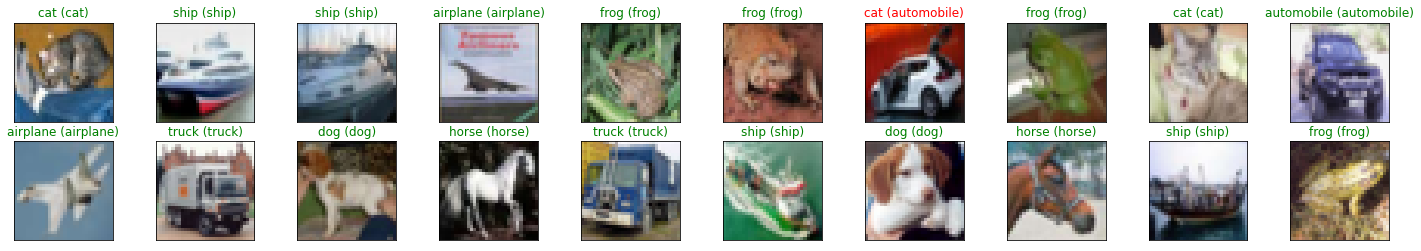

In [12]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

train_on_gpu = torch.cuda.is_available()

# move model inputs to cuda, if GPU available
images = images.to(device)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))